# Predict which target a group of terrorists is attacking based on statistics

In [1]:
import math
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

% matplotlib notebook
% matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# View the data
NOTE:
The unzipped CSV file downloaded from https://www.kaggle.com/START-UMD/gtd/data, has a default 'mac_roman' encoding

In [2]:
df=pd.read_csv('globalterrorismdb_0617dist.csv', encoding='mac_roman', low_memory=False)
df.shape

(170350, 135)

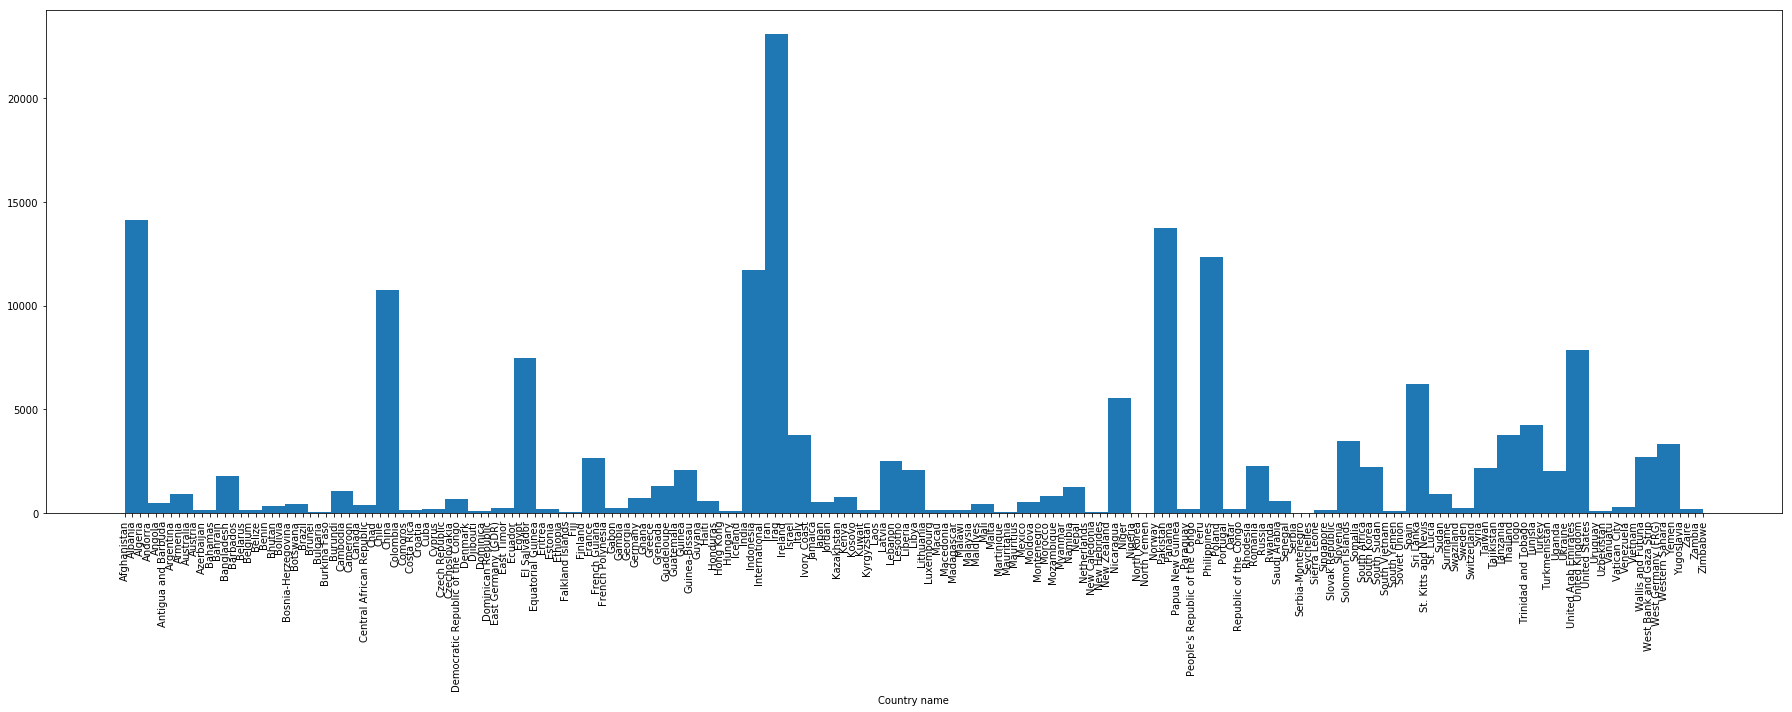

In [4]:
_ = plt.figure(figsize=(25,10))
_ = plt.hist(df['country_txt'], bins='auto', )
_ = plt.xlabel("Country name")
_ = plt.xticks(rotation='vertical')
_ = plt.tight_layout()

# Create subset of data
The code below limits the range of years and determines the top 5 countries in numbers of terrorist attacks:

In [5]:
fromyear=2012
toyear=2018
clist=df['country'].unique().tolist()
clist.sort()
ccount=[]
cname=[]
for country in clist:
    ccount.append(df['iyear'][(df['country']==country) & (df['iyear']>fromyear) & (df['iyear']<toyear)].count())
countrycounts=pd.DataFrame({'country code': clist, 'nr_att': ccount})

In [6]:
countrycounts = countrycounts.sort_values(by='nr_att', ascending=False)

In [7]:
countryname=[]
ccodelist=countrycounts['country code'].tolist()
for ccode in ccodelist:
    countryname.append(df['country_txt'][df['country']==ccode].head(1).tolist()[0])
countrycounts['country name']=countryname
countrycounts.head()

,country code,nr_att,country name
80,95,12875,Iraq
0,4,6804,Afghanistan
126,153,6461,Pakistan
77,92,3456,India
132,160,2600,Philippines


In [8]:
country_1 = countrycounts['country code'].head(1).tolist()[0]
tgroup=df['gname'][(df['country'] == country_1) & (df['iyear']>fromyear) & (df['iyear']<toyear)].unique().tolist()
len(tgroup)

19

In [9]:
tgroup.sort()
tgroup

['Abu Jaafar al-Mansur Brigades',
 'Al-Naqshabandiya Army',
 'Al-Nusrah Front',
 'Al-Qaida in Iraq',
 'Ansar al-Islam',
 "Asa'ib Ahl al-Haqq",
 'Death Squad (Iraq)',
 'Harakat al-Nujaba',
 'Islamic State of Iraq and the Levant (ISIL)',
 "Kata'ib Hezbollah",
 'Kurdish Democratic Party-Iraq (KDP)',
 "Kurdistan Workers' Party (PKK)",
 'Military Council of the Tribal Revolutionaries (MCTR)',
 'Mujahedeen Army',
 'Mukhtar Army',
 'Muslim extremists',
 'Popular Mobilization Forces (Iraq)',
 'Tribesmen',
 'Unknown']

# <b>Prepare Data </b>

Steps: <br>
- Clean the data <br>
- Impute missing values <br>
- Create dummy variables <br>
- Create the train-test split <br>

### Clean the data

Remove all "_txt" columns AS they already have a numeric equivalent: e.g. 'country_txt' - 'country'

In [10]:
data=df.copy()
data = data[(data['country']==country_1) & (data['iyear'] > fromyear) & (data['iyear'] < toyear) &
            (data['crit1']==1) & 
            (data['crit2']==1) & 
            (data['crit3']==1) & 
            (data['doubtterr']==0) &
            (data['guncertain1']==0)]
filter_col = [col for col in df.iloc[0:,3:] if col.endswith('_txt')]
data = data.drop(filter_col, axis=1)
data.shape

(10961, 107)

Remove the overhead columns:
- 'approxdate' AS the event date is recorded in (iyear, imonth, iday) fields
- 'provstate' and 'city' AS the event location is accurately describe by the (country, region, latitude, longitude) fields
- 'location' and 'summary' AS they are providing detailed explanations on the registered event, data already captured in standardized language 
- 'corp1', 'target1', 'corp2', 'target2', 'corp3', 'target3' AS they are detailed explanations of the fields (targtype1, targsubtype1, targtype2, targsubtype2, targtype3, targsubtype3)
- 'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3' AS we are targeting the highest group organisation, recorded in 'gname'
- 'motive' relevant field, but poorly standardized. We decided to remove it as does not serve the purpose of our study case
- 'weapdetail' AS it provides detailed explanation on the following fields: (weaptype1, weapsubtype1, weaptype2, weapsubtype2, weaptype3, weapsubtype3, weaptype4, weapsubtype4)
- 'propcomment' AS the Property Damage value is captured in (propvalue) field
- 'ransomnote', 'addnotes' AS they provide detailed explanations about the kidnap attack recorded in (ishostkid : nrelesed) fields
- 'scite1', 'scite2', 'scite3' AS they are media records representing the First, Second and Third First Source Citation
- 'related' AS it does not provide context to our study case


In [11]:
discard_col = ['approxdate', 'provstate', 'city', 'location', 'summary', 'corp1', 'target1', 'corp2', 'target2', 
               'corp3', 'target3', 'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3', 
               'motive', 'weapdetail', 'propcomment', 'ransomnote', 'addnotes', 'scite1', 'scite2', 'scite3', 
               'related']
data = data.drop(discard_col, axis=1)
data.shape

(10961, 82)

Transform date columns to datetime: e.g. 'resolution'

In [12]:
data['resolution'] = pd.to_datetime(data['resolution'])

Before converting iyear, iday and imonth to datetime, study the number of 0 values in these columns:

In [13]:
float(df[df['iday']==0].shape[0])/float(df.shape[0])

0.005230407983563252

In [14]:
float(df[df['imonth']==0].shape[0])/float(df.shape[0])

0.00011740534194305841

In [15]:
float(df[df['iyear']==0].shape[0])/float(df.shape[0])

0.0

Remove rows where day or month are 0; otherwise they cannot be converted to datetimes.
* Get indices of rows where iday=0 and imonth=0 respectively
* Since they are relatively few (less than 1 out of 1000) we decide to drop them.

In [16]:
drop_idx=data['iday'][data['iday']==0].index.tolist()
data = data.drop(labels=drop_idx, axis=0)

In [17]:
drop_idx=data[data['imonth']==0].index.tolist()
data=data.drop(labels=drop_idx, axis=0)

In [18]:
data.shape

(10961, 82)

In [22]:
data.shape

(10961, 82)

In [23]:
dropcols = ['eventid',# 'iyear', 'imonth', 'iday', 
            'resolution', 'country', 'region', 'crit1', 'crit2', 'crit3', 
            'alternative', 'country', 'region', 'guncertain1', 'guncertain2', 'guncertain3', 'attacktype2',
            'attacktype3', 'claimed', 'claimmode2', 'claimmode3', 'compclaim', 'claim2', 'claim3', 'divert', 
            'kidhijcountry', 'nreleased', 
            'property', 'propextent', 'propvalue', 'ransom', 'ransomamt', 'ransomamtus', 'ransompaid', 'ransompaidus',
            'doubtterr', 'dbsource', 'individual', 'natlty2', 'natlty3', 'ndays', 'nhostkidus', 'nhours', 'nkillus', 
            'nperpcap', 'nwoundte', 'nwoundus', 'targsubtype1','targsubtype3','targsubtype2', 'targtype2', 'targtype3','weapsubtype1',
            'weapsubtype3','weapsubtype4', 'weaptype4']
data = data.drop(dropcols, axis=1)
data_cols=data.columns.values.tolist()
data_cols.sort()
data_cols

['INT_ANY',
 'INT_IDEO',
 'INT_LOG',
 'INT_MISC',
 'attacktype1',
 'claimmode',
 'extended',
 'gname',
 'hostkidoutcome',
 'iday',
 'imonth',
 'ishostkid',
 'iyear',
 'latitude',
 'longitude',
 'multiple',
 'natlty1',
 'nhostkid',
 'nkill',
 'nkillter',
 'nperps',
 'nwound',
 'specificity',
 'success',
 'suicide',
 'targtype1',
 'vicinity',
 'weapsubtype2',
 'weaptype1',
 'weaptype2',
 'weaptype3']

### Impute missing values

In [24]:
data['nhostkid'].fillna(value=0.0, inplace=True)
mean_nperps=int(round(data['nperps'][data['nperps']>=0.0].mean()))
data['nperps'].fillna(value=mean_nperps, inplace=True)
mean_nkill=int(round(data['nkill'].mean()))
data['nkill'].fillna(value=mean_nkill, inplace=True)
mean_nkillter=int(round(data['nkillter'].mean()))
data['nkillter'].fillna(value=mean_nkillter, inplace=True)
mean_nwound=int(round(data['nwound'][data['nwound']>=0.0].mean()))
data['nwound'].fillna(value=mean_nwound, inplace=True)
data['targtype1'].fillna(value=0.0, inplace=True)
data['weaptype1'].fillna(value=0.0, inplace=True)
data['weaptype2'].fillna(value=0.0, inplace=True)
data['weaptype3'].fillna(value=0.0, inplace=True)
data['weapsubtype2'].fillna(value=0.0, inplace=True)
data['claimmode'].fillna(value=0.0, inplace=True)
data['hostkidoutcome'].fillna(value=0, inplace=True)

In [25]:
data[['attacktype1',
 'claimmode',
 'extended',
 'gname',
 'hostkidoutcome',
 'ishostkid',
 'latitude',
 'longitude',
 'multiple',
 'natlty1']].head(50)

# data.describe().T

,attacktype1,claimmode,extended,gname,hostkidoutcome,ishostkid,latitude,longitude,multiple,natlty1
113154,3,0.0,0,Unknown,0.0,0.0,34.886283,44.629025,1,95.0
113155,3,0.0,0,Unknown,0.0,0.0,34.886283,44.629025,1,95.0
113156,3,0.0,0,Unknown,0.0,0.0,35.471855,44.391518,0,95.0
113166,3,0.0,0,Unknown,0.0,0.0,34.604954,43.685017,1,95.0
113167,3,0.0,0,Unknown,0.0,0.0,34.604328,43.685570,1,95.0
113168,3,0.0,0,Unknown,0.0,0.0,34.613996,43.674560,0,95.0
113170,1,0.0,0,Unknown,0.0,0.0,35.467381,44.378843,0,95.0
113179,3,0.0,0,Unknown,0.0,0.0,33.291944,44.065556,0,95.0
113188,2,0.0,0,Unknown,0.0,0.0,33.664461,44.373944,0,95.0
113189,2,0.0,0,Unknown,0.0,0.0,36.344997,43.129363,0,95.0


,count,mean,std,min,25%,50%,75%,max
iyear,10961.0,2014.545479,1.100828,2013.000000,2014.000000,2014.000000,2016.000000,2016.000000
imonth,10961.0,6.597026,3.486981,1.000000,4.000000,7.000000,10.000000,12.000000
iday,10961.0,15.798832,8.764245,1.000000,8.000000,16.000000,23.000000,31.000000
extended,10961.0,0.031293,0.174116,0.000000,0.000000,0.000000,0.000000,1.000000
latitude,10911.0,33.975427,1.075987,29.167840,33.305118,33.423383,34.599964,36.929481
longitude,10911.0,44.039598,0.776788,38.908668,43.682889,44.318868,44.425400,48.471969
specificity,10961.0,1.262202,0.724596,1.000000,1.000000,1.000000,1.000000,5.000000
vicinity,10961.0,0.059027,0.235687,0.000000,0.000000,0.000000,0.000000,1.000000
multiple,10961.0,0.183012,0.386694,0.000000,0.000000,0.000000,0.000000,1.000000
success,10961.0,0.879755,0.325262,0.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
categoricalcols=data.columns.tolist()
nocatcols=['latitude',
           'longitude',
           'nhostkid',
           'nkill',
           'nkillter',
           'nperps',
           'nwound',
           'targtype1',
           'iyear', 
           'imonth', 
           'iday'
          ]
for nocatcol in nocatcols:
    categoricalcols.remove(nocatcol)
    
for category in categoricalcols:
    data[category]=data[category].astype('category')

### Create dummy variables 

In [27]:
#Drop the target variable 
rest = data.drop('gname', axis=1)

rest = rest.replace([np.inf,-np.inf], np.nan)
rest = rest.dropna()
#Generate dummies for all remaining categorical variables
rest.shape
rest = pd.get_dummies(rest)

cols = list(rest)
nunique = rest.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index

rest = rest.drop(cols_to_drop, axis=1)

rest = rest.loc[:, rest.std() > .03]
rest.shape

(10908, 30)

(10908, 79)

### Create train-test split
The split is 0.25/0.75 by default

In [28]:
pd.options.mode.chained_assignment = None
data1 = rest
nums = data1._get_numeric_data().columns
nums = data1.columns
print(nums)
#data1.drop('gname', axis=1, inplace = True)
#data = data.replace('Unknown', np.nan)
data1 = data1.dropna()
#data[nums] = data[nums][~data.isin([np.nan, np.inf, -np.inf]).any(1)].astype(np.float64)
data2 = data1

counts = data1['targtype1'].value_counts()
data1 = data1[data1['targtype1'].isin(counts[counts >= 3].index)]
# 1. Extract Y
# prepare two versions one where the rare classes are removed and the other to use to generate random sampling 

y = data1['targtype1']
y2= data2['targtype1']

# 2. Extract X
#X = data[nums]

X = data1.drop('targtype1', axis=1)
X2 = data2.drop('targtype1', axis=1)
X.head()

Index(['iyear', 'imonth', 'iday', 'latitude', 'longitude', 'targtype1',
       'nperps', 'nkill', 'nkillter', 'nwound', 'nhostkid', 'extended_0',
       'extended_1', 'specificity_1.0', 'specificity_2.0', 'specificity_3.0',
       'specificity_4.0', 'vicinity_0', 'vicinity_1', 'multiple_0',
       'multiple_1', 'success_0', 'success_1', 'suicide_0', 'suicide_1',
       'attacktype1_1', 'attacktype1_2', 'attacktype1_3', 'attacktype1_5',
       'attacktype1_6', 'attacktype1_7', 'attacktype1_9', 'natlty1_94.0',
       'natlty1_95.0', 'claimmode_0.0', 'claimmode_4.0', 'claimmode_6.0',
       'claimmode_7.0', 'claimmode_8.0', 'claimmode_10.0', 'weaptype1_2',
       'weaptype1_5', 'weaptype1_6', 'weaptype1_8', 'weaptype1_9',
       'weaptype1_13', 'weaptype2_0.0', 'weaptype2_5.0', 'weaptype2_6.0',
       'weaptype2_8.0', 'weaptype2_9.0', 'weaptype2_13.0', 'weapsubtype2_0.0',
       'weapsubtype2_2.0', 'weapsubtype2_5.0', 'weapsubtype2_11.0',
       'weapsubtype2_13.0', 'weapsubtype2_16.0', '

,iyear,imonth,iday,latitude,longitude,nperps,nkill,nkillter,nwound,nhostkid,...,INT_LOG_-9,INT_LOG_0,INT_IDEO_-9,INT_IDEO_0,INT_IDEO_1,INT_MISC_0,INT_MISC_1,INT_ANY_-9,INT_ANY_0,INT_ANY_1
113154,2013,1,1,34.886283,44.629025,-99.0,1.0,0.0,5.0,0.0,...,1,0,1,0,0,1,0,1,0,0
113155,2013,1,1,34.886283,44.629025,-99.0,0.0,0.0,5.0,0.0,...,1,0,1,0,0,1,0,1,0,0
113156,2013,1,1,35.471855,44.391518,-99.0,0.0,0.0,2.0,0.0,...,1,0,1,0,0,1,0,1,0,0
113166,2013,1,1,34.604954,43.685017,-99.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,0,1,0,0
113167,2013,1,1,34.604328,43.685570,-99.0,0.0,0.0,3.0,0.0,...,1,0,1,0,0,1,0,1,0,0


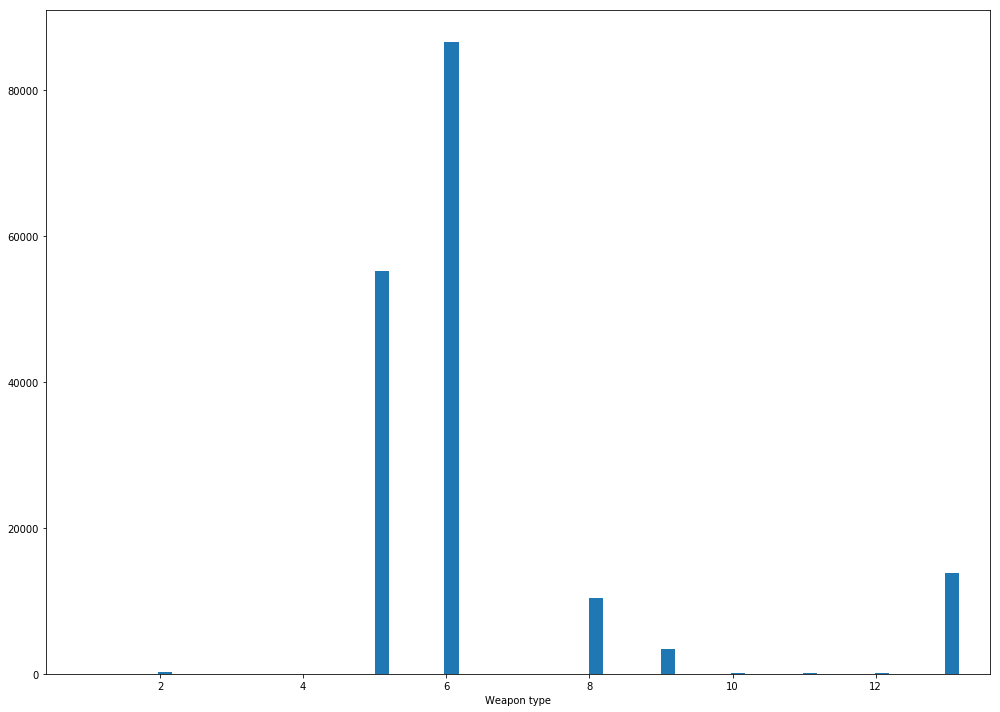

In [29]:
_ = plt.figure(figsize=(14,5))
_ = plt.hist(df['weaptype1'], bins='auto', width=.2)
_ = plt.xlabel("Weapon type")
_ = plt.tight_layout()

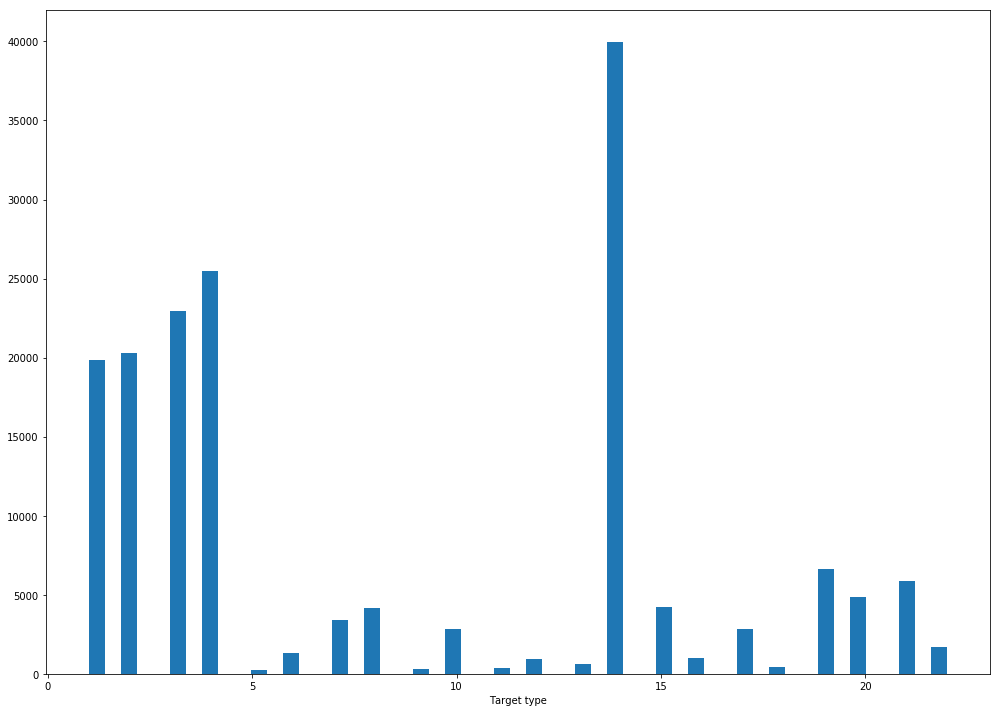

In [30]:
_ = plt.figure(figsize=(14,5))
_ = plt.hist(df['targtype1'], bins='auto')
_ = plt.xlabel("Target type", fontsize=25)
_ = plt.tight_layout()

In [31]:
#3. Create train-test split

#With prior installation of 'imblearn' Python package, a toolbox for imbalanced dataset in machine learning
from imblearn.over_sampling import RandomOverSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42)
X_train.dtypes
print(X_train.describe().T)
print(X2_train.describe().T)
#X_train.shape
#X_test.shape

ros = RandomOverSampler() 
X_train_oversample, y_train_oversample = ros.fit_sample(X2_train, y2_train)
X_train_oversample.shape

iyear                   int64
imonth                  int64
iday                    int64
latitude              float64
longitude             float64
nperps                float64
nkill                 float64
nkillter              float64
nwound                float64
nhostkid              float64
extended_0              uint8
extended_1              uint8
specificity_1.0         uint8
specificity_2.0         uint8
specificity_3.0         uint8
specificity_4.0         uint8
vicinity_0              uint8
vicinity_1              uint8
multiple_0              uint8
multiple_1              uint8
success_0               uint8
success_1               uint8
suicide_0               uint8
suicide_1               uint8
attacktype1_1           uint8
attacktype1_2           uint8
attacktype1_3           uint8
attacktype1_5           uint8
attacktype1_6           uint8
attacktype1_7           uint8
                       ...   
weaptype2_8.0           uint8
weaptype2_9.0           uint8
weaptype2_

                     count         mean        std          min          25%  \
iyear               8178.0  2014.548912   1.097817  2013.000000  2014.000000   
imonth              8178.0     6.595867   3.486085     1.000000     4.000000   
iday                8178.0    15.866226   8.733941     1.000000     8.000000   
latitude            8178.0    33.969886   1.076441    29.167840    33.305081   
longitude           8178.0    44.039697   0.783590    38.908668    43.683236   
nperps              8178.0   -90.250917  29.469923   -99.000000   -99.000000   
nkill               8178.0     2.994742  12.604902     0.000000     0.000000   
nkillter            8178.0     0.495720   3.374804     0.000000     0.000000   
nwound              8178.0     5.001590  18.274024     0.000000     0.000000   
nhostkid            8178.0     1.141110  34.980903   -99.000000     0.000000   
extended_0          8178.0     0.969797   0.171156     0.000000     1.000000   
extended_1          8178.0     0.030203 

(70686, 78)

# Build the Model

Text(0.5,1,'F values')

Text(0.5,1,'p values')

[Text(0,0,'iyear'),
 Text(0,0,'imonth'),
 Text(0,0,'iday'),
 Text(0,0,'latitude'),
 Text(0,0,'longitude'),
 Text(0,0,'nperps'),
 Text(0,0,'nkill'),
 Text(0,0,'nkillter'),
 Text(0,0,'nwound'),
 Text(0,0,'nhostkid'),
 Text(0,0,'extended_0'),
 Text(0,0,'extended_1'),
 Text(0,0,'specificity_1.0'),
 Text(0,0,'specificity_2.0'),
 Text(0,0,'specificity_3.0'),
 Text(0,0,'specificity_4.0'),
 Text(0,0,'vicinity_0'),
 Text(0,0,'vicinity_1'),
 Text(0,0,'multiple_0'),
 Text(0,0,'multiple_1'),
 Text(0,0,'success_0'),
 Text(0,0,'success_1'),
 Text(0,0,'suicide_0'),
 Text(0,0,'suicide_1'),
 Text(0,0,'attacktype1_1'),
 Text(0,0,'attacktype1_2'),
 Text(0,0,'attacktype1_3'),
 Text(0,0,'attacktype1_5'),
 Text(0,0,'attacktype1_6'),
 Text(0,0,'attacktype1_7'),
 Text(0,0,'attacktype1_9'),
 Text(0,0,'natlty1_94.0'),
 Text(0,0,'natlty1_95.0'),
 Text(0,0,'claimmode_0.0'),
 Text(0,0,'claimmode_4.0'),
 Text(0,0,'claimmode_6.0'),
 Text(0,0,'claimmode_7.0'),
 Text(0,0,'claimmode_8.0'),
 Text(0,0,'claimmode_10.0'),


([<matplotlib.axis.XTick at 0x1a2060d208>,
 <a list of 78 Text xticklabel objects>)

([<matplotlib.axis.YTick at 0x117158860>,
 <a list of 78 Text yticklabel objects>)

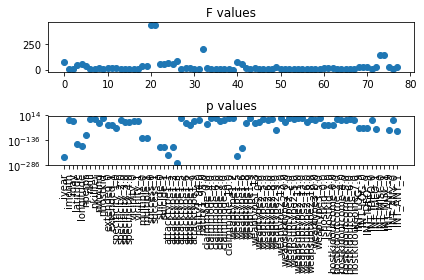

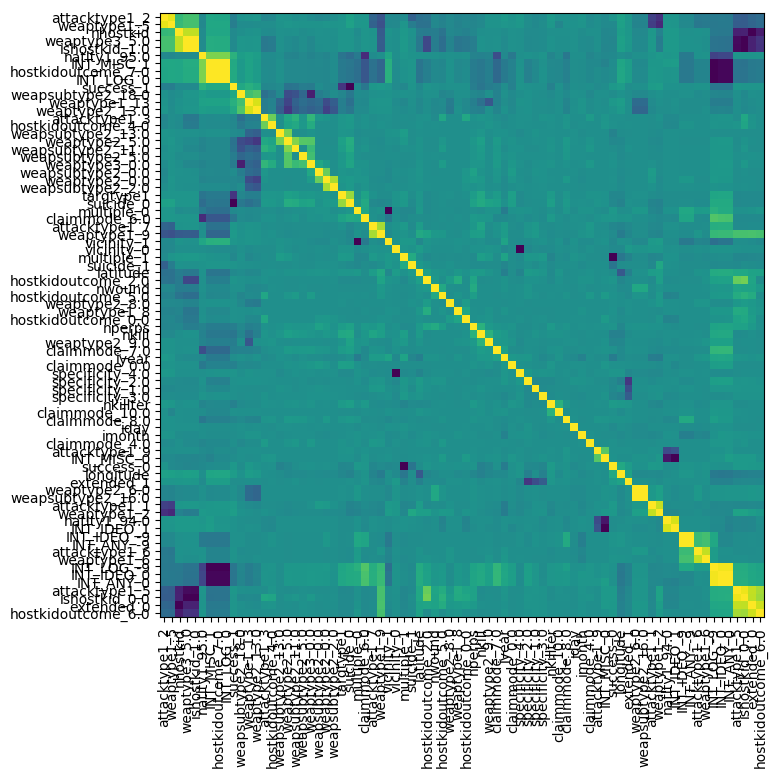

In [32]:
from sklearn.preprocessing import scale,StandardScaler
X_train_scaled = scale(X_train)
cov = np.cov(X_train_scaled, rowvar=False)
plt.figure(figsize=(20,20), dpi=50)

from sklearn.feature_selection import f_classif, f_regression
f_values, p_values = f_classif(X, y)

fig, ax = plt.subplots(2, 1)
_ = ax[0].set_title("F values")
_ = ax[0].plot(f_values, 'o')
_ = ax[1].set_title("p values")
_ = ax[1].plot(p_values, 'o')
_ = ax[1].set_yscale("log")
_ = ax[1].set_xticks(range(X.shape[1]))
_ = ax[1].set_xticklabels(X.columns, rotation=90);
_ = fig.tight_layout()

from scipy.cluster import hierarchy
order = np.array(hierarchy.dendrogram(hierarchy.ward(cov), no_plot=True)['ivl'], dtype="int")

_ = plt.figure(figsize=(8, 8), dpi=100)
_ = plt.imshow(cov[order, :][:, order])
_ = plt.xticks(range(X.shape[1]), data1.columns[order], rotation=90)
_ = plt.yticks(range(X.shape[1]), data1.columns[order]);

from sklearn.feature_selection import SelectPercentile, SelectKBest, SelectFromModel, VarianceThreshold   

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

def build_run_pipeline_no_imp(feature_selection, scaler, model, param,scoring_type,
                             xtrain, ytrain, xtest, ytest):
    pipeline = Pipeline(steps=[
        ('select', feature_selection),
        ('standardize', scaler),
        ('model', model)
    ])


    param_grid = param
    grid3 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, return_train_score=True, )
    grid3.fit(xtrain, ytrain)
    print("best mean cross-validation score: {:.3f}".format(grid3.best_score_))
    print(grid3.best_params_)
    print(grid3.score(xtest, ytest))
    
    
    pred = grid3.best_estimator_.predict(xtest)
    print("Accuracy score = {:.1f}%".format(100.0*accuracy_score(ytest, pred)))
    
    #if scoring_type:
    #    print("Test set {} score: {:.3f}".format(scoring_type, roc_auc_score(y_test, grid3.decision_function(X_test))))
    
    
    if feature_selection != None:
        select_indices = grid3.best_estimator_.named_steps['select'].transform(np.arange(len(xtrain.columns)).reshape(1, -1))
        print (xtrain.columns[select_indices ])
    return grid3


In [34]:
# LinearSVC
from sklearn.svm import LinearSVC

build_run_pipeline_no_imp(feature_selection = SelectKBest(k=7, score_func=f_regression),
                          scaler = StandardScaler(), 
                          model =LinearSVC(max_iter = 10e3),
                          param = {'model__C': np.logspace(-6,3,11)},
                          scoring_type = "f1_macro",
                          #xtrain = X_train_oversample, y_train = y_train_oversample, 
                          xtrain = X_train, ytrain = y_train,
                          xtest = X_test, 
                          ytest = y_test)

best mean cross-validation score: 0.477
{'model__C': 0.03162277660168379}
0.4739545121056493
Accuracy score = 47.4%
Index([['iyear', 'success_0', 'success_1', 'attacktype1_2', 'attacktype1_3', 'weaptype1_5', 'weaptype1_6']], dtype='object')


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('select', SelectKBest(k=7, score_func=<function f_regression at 0x1a2034ae18>)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000.0,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__C': array([1.00000e-06, 7.94328e-06, 6.30957e-05, 5.01187e-04, 3.98107e-03,
       3.16228e-02, 2.51189e-01, 1.99526e+00, 1.58489e+01, 1.25893e+02,
       1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [35]:
# LogisticRegression

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, Normalizer
from sklearn.feature_selection import RFECV, SelectFromModel, SelectPercentile, SelectKBest

build_run_pipeline_no_imp(feature_selection = SelectKBest(k=7, score_func=f_classif),
                          scaler = StandardScaler(), 
                          model = LogisticRegression(solver = "lbfgs",  penalty="l2", multi_class = "multinomial", max_iter  = 10e3),
                          param = {'model__C': np.logspace(-6,3,11)},
                          scoring_type = "f1_macro",
                          #xtrain = X_train_oversample, ytrain = y_train_oversample, 
                          xtrain = X_train, ytrain = y_train,
                          xtest = X_test, 
                          ytest = y_test)

best mean cross-validation score: 0.472
{'model__C': 0.25118864315095824}
0.4706529713866471
Accuracy score = 47.1%
Index([['iyear', 'success_0', 'success_1', 'attacktype1_3', 'natlty1_95.0', 'INT_MISC_0', 'INT_MISC_1']], dtype='object')


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('select', SelectKBest(k=7, score_func=<function f_classif at 0x1a2034ac80>)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000.0, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__C': array([1.00000e-06, 7.94328e-06, 6.30957e-05, 5.01187e-04, 3.98107e-03,
       3.16228e-02, 2.51189e-01, 1.99526e+00, 1.58489e+01, 1.25893e+02,
       1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [36]:
# # A variation of the "build_run_pipeline_no_imp" function, which allows for empty feature_selection, scaler or model. 
# # Also, it allows passing a scoring attribute for GridSeach

# from sklearn.pipeline import Pipeline

# def build_run_pipeline_no_imp2(feature_selection, scaler, model, param, scoring_type,
#                              x_train, y_train, x_test, y_test):

#     #build the pipeline 
#     pipe_steps = []
#     pipe_steps.append(['select', feature_selection]) if feature_selection else None
#     pipe_steps.append(['standardize', scaler]) if scaler else None
#     pipe_steps.append(['model', model]) if model else None
#     pipeline = Pipeline(steps=pipe_steps)

#     #initialize and fit GridSearch
#     scor = "accuracy" if not scoring else scoring
#     grid3 = GridSearchCV(estimator=pipeline, param_grid=param, scoring=scor, cv=5, return_train_score=True)
#     grid3.fit(x_train, y_train)
    
#     #display the results
#     print("Best mean cross-validation score: {:.3f}".format(grid3.best_score_))
#     print(grid3.best_params_)
    
#     print("Test set accuracy score: {:.3f}".format(grid3.score(X_test, y_test)))
#     if scoring_type:
#         print("Test set {} score: {:.3f}".format(scoring, roc_auc_score(y_test, grid3.decision_function(X_test))))
    

#     select_indices = grid3.best_estimator_.named_steps['select'].transform(np.arange(len(X_train.columns)).reshape(1, -1))
#     print("Selected features: ", X_train.columns[select_indices])
    
#     return grid3.cv_results_


In [37]:
# RandomForest 
# feature_selection: RandomForest doesn't need a feature selector pre-defined, as the algorithm selects by default the most important features
# scaler: RandomForest doesn't require scaling of the data 
# model: RandomForestClassifier is one of the most widely used classification algorithms 
# scoring: Metrics'f1_macro' is used, for a better model evaluation on a multiclass classification with inbalanced data

from sklearn.ensemble import RandomForestClassifier

mod = build_run_pipeline_no_imp(feature_selection = None,
                                scaler = None, 
                                model = RandomForestClassifier(n_jobs=-1, random_state=42),
                                param = {'model__max_depth': np.arange(1, 8), 'model__n_estimators': np.arange(100, 500, 50), 'model__max_features': np.arange(4, 8)},
                                scoring_type = "f1_macro",
                                #xtrain = X_train_oversample, ytrain = y_train_oversample, 
                                xtrain = X_train, ytrain = y_train,
                                xtest = X_test, 
                                ytest = y_test);

          

best mean cross-validation score: 0.522
{'model__max_depth': 7, 'model__max_features': 7, 'model__n_estimators': 300}
0.5154071900220103
Accuracy score = 51.5%


In [38]:
#mod.best_estimator_.named_steps['model'].feature_importances_

elements = sorted(zip(map(lambda x: round(x, 4), mod.best_estimator_.named_steps['model'].feature_importances_), X_train.columns), 
             reverse=True)
elements
lst = [x[1] for x in elements]
print( "Indexes[" + ','.join(lst[:25]) + "]")
       

[(0.1074, 'nwound'),
 (0.0946, 'success_1'),
 (0.0926, 'success_0'),
 (0.0815, 'longitude'),
 (0.0634, 'latitude'),
 (0.0535, 'iyear'),
 (0.047, 'nkill'),
 (0.0364, 'attacktype1_3'),
 (0.0308, 'iday'),
 (0.0263, 'weaptype1_5'),
 (0.025, 'attacktype1_1'),
 (0.0243, 'nkillter'),
 (0.0235, 'imonth'),
 (0.0234, 'attacktype1_2'),
 (0.0215, 'weaptype1_6'),
 (0.0215, 'suicide_1'),
 (0.0184, 'suicide_0'),
 (0.0165, 'nperps'),
 (0.0133, 'multiple_0'),
 (0.0126, 'INT_IDEO_1'),
 (0.0116, 'multiple_1'),
 (0.0116, 'INT_IDEO_-9'),
 (0.0111, 'INT_ANY_1'),
 (0.0107, 'INT_LOG_-9'),
 (0.0104, 'INT_LOG_0'),
 (0.0099, 'INT_ANY_-9'),
 (0.007, 'specificity_1.0'),
 (0.0063, 'specificity_3.0'),
 (0.0058, 'nhostkid'),
 (0.005, 'attacktype1_7'),
 (0.0046, 'weaptype2_0.0'),
 (0.0041, 'vicinity_0'),
 (0.004, 'weaptype1_8'),
 (0.0039, 'weaptype1_13'),
 (0.0038, 'vicinity_1'),
 (0.0038, 'claimmode_0.0'),
 (0.0034, 'weapsubtype2_0.0'),
 (0.0033, 'attacktype1_9'),
 (0.0029, 'specificity_4.0'),
 (0.0029, 'claimmode_7.

Indexes[nwound,success_1,success_0,longitude,latitude,iyear,nkill,attacktype1_3,iday,weaptype1_5,attacktype1_1,nkillter,imonth,attacktype1_2,weaptype1_6,suicide_1,suicide_0,nperps,multiple_0,INT_IDEO_1,multiple_1,INT_IDEO_-9,INT_ANY_1,INT_LOG_-9,INT_LOG_0]


In [39]:
# KNN
# feature_selection: We uae SelectFromModel automatic feature selector, with RandomForestClassifier algorithm
# scaler: We use StandardScaler, which ensures that for each feature the mean is 0 and te variance is 1 
# model: KNN is one of the most common classification models
# scoring: Metrics'f1_macro' is used, for a better model evaluation on a multiclass classification with inbalanced data

from sklearn.neighbors import KNeighborsClassifier

build_run_pipeline_no_imp(feature_selection = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median'),
                          scaler = StandardScaler(), 
                          model = KNeighborsClassifier(),
                          param = {'model__n_neighbors':np.arange(1, 17, 2)},
                          scoring_type = "f1_macro",
                          #xtrain = X_train_oversample, ytrain = y_train_oversample, 
                          xtrain = X_train, ytrain = y_train,
                          xtest = X_test, 
                          ytest = y_test);



best mean cross-validation score: 0.504
{'model__n_neighbors': 15}
0.5029347028613352
Accuracy score = 50.3%
Index([['iyear', 'imonth', 'iday', 'latitude', 'longitude', 'nperps', 'nkill', 'nkillter', 'nwound', 'nhostkid', 'specificity_1.0', 'specificity_2.0', 'specificity_3.0', 'specificity_4.0', 'vicinity_0', 'vicinity_1', 'multiple_0', 'multiple_1', 'success_0', 'success_1', 'suicide_0', 'suicide_1', 'attacktype1_1', 'attacktype1_2', 'attacktype1_3', 'attacktype1_9', 'claimmode_0.0', 'claimmode_7.0', 'claimmode_8.0', 'weaptype1_5', 'weaptype1_6', 'weaptype1_13', 'weaptype2_0.0', 'INT_LOG_-9', 'INT_LOG_0', 'INT_IDEO_-9', 'INT_IDEO_1', 'INT_ANY_-9', 'INT_ANY_1']], dtype='object')


In [40]:
# LinearSVC with different feature selection
# feature_selection: We uae SelectFromModel automatic feature selector, with RandomForestClassifier algorithm
# scaler: We use StandardScaler, which ensures that for each feature the mean is 0 and te variance is 1 
# model: LinearSVC is one of the most common classification liniar models, here we use it with the default L2 regularization
# scoring: Metrics'f1_macro' is used, for a b etter model evaluation on a multiclass classification with inbalanced data

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

build_run_pipeline_no_imp(feature_selection = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median'),
                          scaler = StandardScaler(), 
                          model = LinearSVC(),
                          param = {'model__C': np.power(10.0, np.arange(-5, 5))},
                          scoring_type = "f1_macro",
                          #xtrain = X_train_oversample, ytrain = y_train_oversample, 
                          xtrain = X_train, ytrain = y_train,
                          xtest = X_test, 
                          ytest = y_test);


best mean cross-validation score: 0.509
{'model__C': 1.0}
0.5099046221570066
Accuracy score = 51.0%
Index([['iyear', 'imonth', 'iday', 'latitude', 'longitude', 'nperps', 'nkill', 'nkillter', 'nwound', 'nhostkid', 'specificity_1.0', 'specificity_2.0', 'specificity_3.0', 'specificity_4.0', 'vicinity_0', 'vicinity_1', 'multiple_0', 'multiple_1', 'success_0', 'success_1', 'suicide_0', 'suicide_1', 'attacktype1_1', 'attacktype1_2', 'attacktype1_3', 'attacktype1_9', 'claimmode_0.0', 'claimmode_7.0', 'claimmode_8.0', 'weaptype1_5', 'weaptype1_6', 'weaptype1_13', 'weaptype2_0.0', 'INT_LOG_-9', 'INT_LOG_0', 'INT_IDEO_-9', 'INT_IDEO_1', 'INT_ANY_-9', 'INT_ANY_1']], dtype='object')


In [41]:
# GradientBoostingClassifier
# feature_selection: GradientBoostingClassifier doesn't need a feature selector as the algorithm considers the most important features
# scaler: GradientBoostingClassifier works well without scaling 
# model: GradientBoostingClassifier is among the most powerful and widely used algorithms 
# scoring: Metrics'f1_macro' is used, for a better model evaluation on a multiclass classification with inbalanced data

from sklearn.ensemble import GradientBoostingClassifier 

mod = build_run_pipeline_no_imp(feature_selection = None,
                                scaler = None,
                                model = GradientBoostingClassifier(max_depth = 5, n_estimators=100, random_state=42),
                                param = {'model__learning_rate': np.arange(0.005, 0.5, 0.05)},
                                scoring_type = "f1_macro",
                                #xtrain = X_train_oversample, ytrain = y_train_oversample,
                                xtrain = X_train, ytrain = y_train,
                                xtest = X_test,
                                ytest = y_test);

#'model_max_depth': np.arange(1, 5), 

best mean cross-validation score: 0.564
{'model__learning_rate': 0.10500000000000001}
0.5663976522377109
Accuracy score = 56.6%


In [42]:
elements1 = sorted(zip(map(lambda x: round(x, 4), mod.best_estimator_.named_steps['model'].feature_importances_), X_train.columns), 
             reverse=True)
elements1
lst = [x[1] for x in elements1]
print( "Indexes[" + ','.join(lst[:16]) + "]")

[(0.2539, 'latitude'),
 (0.2184, 'longitude'),
 (0.0774, 'iday'),
 (0.0707, 'nwound'),
 (0.0556, 'imonth'),
 (0.0443, 'nkill'),
 (0.031, 'iyear'),
 (0.0119, 'success_0'),
 (0.0114, 'multiple_1'),
 (0.0102, 'nkillter'),
 (0.01, 'natlty1_95.0'),
 (0.0099, 'multiple_0'),
 (0.0098, 'success_1'),
 (0.0089, 'nperps'),
 (0.0086, 'attacktype1_2'),
 (0.0083, 'nhostkid'),
 (0.0067, 'attacktype1_3'),
 (0.0058, 'claimmode_8.0'),
 (0.0057, 'specificity_3.0'),
 (0.0057, 'attacktype1_1'),
 (0.0048, 'claimmode_7.0'),
 (0.0047, 'specificity_2.0'),
 (0.0046, 'vicinity_1'),
 (0.0046, 'specificity_4.0'),
 (0.0042, 'weaptype1_5'),
 (0.0041, 'weaptype1_6'),
 (0.0039, 'vicinity_0'),
 (0.0035, 'specificity_1.0'),
 (0.0034, 'hostkidoutcome_4.0'),
 (0.0033, 'natlty1_94.0'),
 (0.003, 'suicide_1'),
 (0.003, 'suicide_0'),
 (0.0029, 'INT_IDEO_1'),
 (0.0027, 'hostkidoutcome_2.0'),
 (0.0026, 'attacktype1_7'),
 (0.0025, 'weapsubtype2_5.0'),
 (0.0024, 'weaptype1_13'),
 (0.0024, 'INT_LOG_-9'),
 (0.0023, 'INT_ANY_1'),
 (

Indexes[latitude,longitude,iday,nwound,imonth,nkill,iyear,success_0,multiple_1,nkillter,natlty1_95.0,multiple_0,success_1,nperps,attacktype1_2,nhostkid]


# Evaluation of the best model

<b>Below each of the runs of the models there is statistics about the accuracy and how far the prediction of the  model is from the real values of y_test. As it to be seen the best model is around 50-60% accurate, where the best result is achieved with GradientBoostingClassifier.</b>

In [46]:
pred = mod.predict(X_test)

In [47]:
confusion_matrix(y_test, pred)

array([[ 68,   5,  10,   1,   0,   0,   0,   0,   0,   0, 215,   1,   0,
          3,   4,   2,   0,   0],
       [  1,  67,  38,   2,   0,   0,   0,   0,   1,   1,  48,   1,   0,
          2,   2,   0,   1,   0],
       [  2,  29, 248,  15,   0,   0,   2,   0,   0,   0, 132,   2,   0,
         15,   1,   5,   1,   1],
       [  2,   1,  30,  27,   0,   0,   1,   0,   0,   0,  35,   2,   0,
         10,   0,   6,   1,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   1,   0,
          0,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   1,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   9,   6,   0,   0,   0,   0,   0,   0,   0,  10,   0,   0,
          1,   0,   1,   1,   0],
       [  0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   4,   0,   0,
          0,   0,   1,   0,   0],
       [  0,   4,   4,   0,   0,   0,   1,   0,   5,   0,   4,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   2,   3,   1,   0,   0,

In [53]:
import warnings
warnings.filterwarnings('ignore') 

#gives a warning for 0/0
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          1       0.49      0.22      0.30       309
          2       0.44      0.41      0.42       164
          3       0.51      0.55      0.53       453
          4       0.43      0.23      0.30       117
          6       0.00      0.00      0.00         4
          7       0.00      0.00      0.00         2
          8       0.00      0.00      0.00        28
          9       0.00      0.00      0.00         6
         10       0.56      0.28      0.37        18
         13       0.50      0.12      0.20        24
         14       0.59      0.80      0.68      1108
         15       0.47      0.24      0.31        59
         16       1.00      1.00      1.00         1
         17       0.39      0.24      0.29       144
         19       0.19      0.06      0.09        50
         20       0.82      0.85      0.84       193
         21       0.77      0.66      0.71        41
         22       0.00      0.00      0.00   

The data is quite imbalanced, as is seen as well from the fact that we had to delete a few classes to make the models work, as those classes had only frequency of 1. An attempt is made to run the model with the oversampled data, however the processing time of such a run is very long.

In [ ]:
# # GradientBoostingClassifier
# # feature_selection: GradientBoostingClassifier doesn't need a feature selector as the algorithm considers the most important features
# # scaler: GradientBoostingClassifier works well without scaling 
# # model: GradientBoostingClassifier is among the most powerful and widely used algorithms 
# # scoring: Metrics'f1_macro' is used, for a better model evaluation on a multiclass classification with inbalanced data

# from sklearn.ensemble import GradientBoostingClassifier 

# mod = build_run_pipeline_no_imp(feature_selection = None,
#                                 scaler = None,
#                                 model = GradientBoostingClassifier(max_depth = 5, n_estimators=100, random_state=42),
#                                 param = {'model__learning_rate': np.arange(0.005, 0.5, 0.05)},
#                                 scoring_type = "f1_macro",
#                                 xtrain = X_train_oversample, ytrain = y_train_oversample,
#                                 xtest = X2_test,
#                                 ytest = y2_test
#                                 #xtrain = X_train, ytrain = y_train,
#                                 #xtest = X_test,
#                                 #ytest = y_test
#                                );

